In [337]:
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import os, boto3, io, sys

BUCKET = os.getenv("BUCKET")
PROCESSED_DATA_FOLDER = os.getenv("PROCESSED_DATA_FOLDER")
PATCH = "patch_15_6/"
CHAMPION_X_ROLE = "champion_x_role_sample.csv"

pd.set_option("display.max_columns", None)

champion_x_role_df = pd.read_csv(CHAMPION_X_ROLE, index_col="champion_name")
display(champion_x_role_df)

,champion_id,team_position,total_games_played_in_role,total_games_per_champion,avg_kills,avg_deaths,avg_deaths_by_enemy_champs,avg_assists,avg_kill_participation,avg_takedowns,total_wins,pct_of_games_with_highest_damage_dealt,avg_pct_damage_dealt_in_team,average_damage_per_minute,avg_damage_dealt_to_champions,avg_total_damage_dealt,avg_magic_damage_dealt_to_champions,avg_total_magic_damage_dealt,avg_physical_damage_dealt_to_champions,avg_total_physical_damage_dealt,avg_true_damage_dealt_to_champions,avg_total_true_damage_dealt,avg_largest_critical_strike,avg_pct_damage_taken_in_team,avg_damage_taken,avg_magic_damage_taken,avg_physical_damage_taken,avg_true_damage_taken,avg_damage_self_mitigated,avg_times_killed_champ_took_full_team_damage_and_survived,avg_times_survived_single_digit_hp,avg_times_survived_three_immobilizes_in_fight,avg_times_took_large_damage_survived,pct_of_games_with_highest_crowd_control_score,avg_time_ccing_others,avg_times_applied_cc_on_others,avg_enemy_champion_immobilizations,avg_total_healing,avg_heals_on_teammate,avg_total_units_healed,avg_dmg_shielded_on_team,avg_effective_heal_and_shield,total_games_completed_supp_quest_first,avg_supp_quest_completion_time,avg_longest_time_spent_alive,avg_time_spent_dead,avg_spell1_casts,avg_spell2_casts,avg_spell3_casts,avg_spell4_casts,avg_ability_uses,avg_times_dodged_skillshot_in_small_window,avg_skillshots_dodged,avg_skillshots_landed_early_game,avg_skillshots_hit,avg_times_immobilize_and_kill_with_ally,avg_times_got_kill_after_hidden_with_ally,avg_times_pick_kill_with_ally,avg_times_knock_enemy_into_team_and_kill,avg_kills_near_enemy_turret,avg_kills_under_own_turret,avg_multikills_after_aggressive_flash,avg_outnumbered_kills,avg_times_outnumbered_nexus_kill,avg_times_quick_cleanse,avg_quick_solo_kills,avg_solo_kills,avg_takedowns_after_gaining_lvl_advantage,avg_kills_on_other_lanes_early_as_laner,avg_times_save_ally_from_death,avg_takedowns_in_alcove,pct_of_games_first_blood_kill,pct_of_games_first_blood_assist,avg_takedowns_before_jungle_camps_spawn,avg_first_takedown_time,avg_summoner_spell1_casts_per_game,avg_summoner_spell2_casts_per_game,pct_of_matches_with_ghost,pct_of_matches_with_cleanse,pct_of_matches_with_smite,pct_of_matches_with_teleport,pct_of_matches_with_exhaust,pct_of_matches_with_ignite,pct_of_matches_with_heal,pct_of_matches_with_flash,pct_of_matches_with_barrier,avg_champ_exp_at_game_end,avg_champ_level_at_game_end,avg_gold_earned_per_game,avg_gold_per_minute,avg_gold_spent,avg_bounty_lvl,avg_bounty_gold,pct_of_games_with_early_lane_phase_gold_exp_adv,pct_of_games_with_lanephase_gold_exp_adv,avg_max_level_lead_over_lane_opp,avg_minions_killed,avg_minions_killed_by_10_mins,avg_max_cs_lead_over_lane_opponent,avg_consumables_purchased,avg_number_of_items_purchased,total_games_fastest_item_completion,avg_items_completed,avg_ally_jungle_minions_killed,avg_enemy_jungle_minions_killed,avg_enemy_jungle_cs_differential_early,avg_jungle_monsters_cs,avg_buffs_stolen,avg_initial_buff_count,avg_epic_monster_kills_within_30s_of_spawn,avg_initial_crab_count,avg_crabs_per_game,avg_jg_cs_before_10m,avg_jungler_kills_early_jungle,avg_jungler_early_kills_on_laners,avg_times_had_early_takedowns_in_all_lanes_as_laner,avg_jungler_takedowns_near_damaged_epic_monsters,avg_kills_with_help_from_epic_monster,avg_vision_score,avg_vision_score_per_min,avg_vision_score_advantage_over_lane_opponent,avg_stealth_wards_placed,avg_wards_placed,avg_wards_guarded,avg_control_wards_placed,avg_control_ward_time_coverage_in_river_or_enemy_half,avg_unseen_recalls,pct_of_games_with_highest_wards_killed,avg_wards_killed,avg_ward_takedowns,avg_ward_takedowns_before_20m,avg_times_2_wards_killed_with_1_sweeper,avg_control_wards_bought,pct_of_games_team_took_first_baron,avg_earliest_baron_by_team_time,pct_of_games_team_took_first_dragon,pct_of_games_team_took_first_inhib,pct_of_games_team_took_first_herald,pct_of_games_team_took_first_turret,avg_baron_kills_by_team,avg_herald_kills_by_te

In [338]:
df = champion_x_role_df
# Creating features
df["total_role_games"] = df.groupby("team_position")["total_games_played_in_role"].transform("sum")
# Popularity metrics
df["popularity_in_role"] = df["total_games_played_in_role"]/df["total_role_games"]
df["role_popularity_for_champion"] = df["total_games_played_in_role"]/df["total_games_per_champion"]
# Damage done metrics
df["pct_magic_damage"] = df["avg_magic_damage_dealt_to_champions"]/df["avg_damage_dealt_to_champions"]
df["pct_physical_damage"] = df["avg_physical_damage_dealt_to_champions"]/df["avg_damage_dealt_to_champions"]
df["pct_true_damage"] = df["avg_true_damage_dealt_to_champions"]/df["avg_damage_dealt_to_champions"]
# Damage taken metrics
df["avg_damage_taken_per_death"] = df["avg_damage_taken"]/df["avg_deaths"]
# JUNGLE (REVISIT UPSTREAM)
df["avg_kills_on_other_lanes_early_as_laner"] = np.where( 
    df["team_position"] != "JUNGLE", 
    df["avg_kills_on_other_lanes_early_as_laner"], # As a laner, in a single game, get kills before 10 minutes outside your lane (anyone but your lane opponent)
    pd.NA
)
df["avg_times_had_early_takedowns_in_all_lanes_as_laner"] = np.where( 
    df["team_position"] != "JUNGLE", 
    df["avg_times_had_early_takedowns_in_all_lanes_as_laner"], # As a laner, in a single game, get kills before 10 minutes outside your lane (anyone but your lane opponent)
    pd.NA
)
df["avg_kills_early_jungle_as_jungler"] = np.where(
    df["team_position"] == "JUNGLE", 
    df["avg_jungler_kills_early_jungle"], # As jungler, get kills on the enemy jungler in their own jungle before 10 minutes
    pd.NA
)
df["avg_early_kills_on_laners_as_jungler"] = np.where(
    df["team_position"] == "JUNGLE", 
    df["avg_jungler_early_kills_on_laners"], # As jungler, get kills on top lane, mid lane, bot lane, or support players before 10 minutes
    pd.NA
)
df["pct_of_matches_with_jungle"] = np.where(
    df["team_position"] == "JUNGLE", 
    df["pct_of_matches_with_jungle"], # As jungler, get kills on top lane, mid lane, bot lane, or support players before 10 minutes
    pd.NA
)
df["avg_enemy_jungle_cs_differential_early"] = np.where(
    df["team_position"] == "JUNGLE", 
    df["avg_enemy_jungle_cs_differential_early"], # As jungler, get kills on top lane, mid lane, bot lane, or support players before 10 minutes
    pd.NA
)
df["avg_supp_quest_completion_time"] = np.where(
    df["team_position"] == "UTILITY", 
    df["avg_supp_quest_completion_time"], # As a support, average support quest completion time
    pd.NA
)

# Structures
df["avg_individual_tower_assists"] = df["avg_individual_tower_takedowns"] - df["avg_individual_tower_kills"]

In [ ]:
labels = ["team_position", "champion_name"]

FEATURES_TO_REMOVE_ALL_ROLES = ["team_position", "mode_individual_position", "mode_lane", "mode_role", "mode_team_position", "champion_id"] #"total_games_played_in_role"]

#avg_mejai_full_stack_time                              33

features_to_remove_jungle = [
    "avg_supp_quest_completion_time", "avg_kills_on_other_lanes_early_as_laner", "avg_times_had_early_takedowns_in_all_lanes_as_laner", 
    "total_games_completed_supp_quest_first", "avg_unreal_kills", "pct_matches_with_heal", "pct_of_matches_with_gold_per", "pct_of_matches_with_cleanse",
    "pct_of_matches_with_exhaust", "pct_of_matches_with_teleport", "pct_of_matches_with_barrier", "pct_of_matches_with_active",
    "avg_takedowns_in_enemy_fountain", "pct_of_matches_with_heal", "total_wins", #"pct_of_games_with_highest_damage_dealt", 
    "avg_largest_critical_strike", "avg_heals_on_teammate", #"pct_of_matches_with_magic_penetration", "avg_times_outnumbered_nexus_kill",
    "pct_of_matches_with_mana",# "pct_of_matches_with_aura", "pct_of_matches_with_mana_regen", "avg_dmg_shielded_on_team", 
    "percent_of_games_with_fully_stacked_mejais",
    "avg_spell4_casts", "pct_of_matches_with_armor_penetration",# "avg_12_assist_streaks", "avg_effective_heal_and_shield", "pct_of_matches_with_slow",
]

features_to_remove_top = ["avg_supp_quest_completion_time", "total_games_completed_supp_quest_first"]

features_to_remove_mid = ["avg_supp_quest_completion_time", "total_games_completed_supp_quest_first"]

features_to_remove_bottom = ["avg_supp_quest_completion_time", "total_games_completed_supp_quest_first"]

features_to_remove_support = [] 


ROLE_FILTER_MAPPING = {
    "JUNGLE": features_to_remove_jungle,
    "TOP": features_to_remove_top,
    "MID": features_to_remove_mid,
    "BOTTOM": features_to_remove_bottom,
    "SUPPORT": features_to_remove_support
}


In [ ]:
# Quick EDA on aggregated_stats.csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def filter_df(df: pd.DataFrame,
              role: str,
              features_to_remove_all_roles: list[str] = FEATURES_TO_REMOVE_ALL_ROLES,
              role_filter_mapping: dict[str, list[str]] = ROLE_FILTER_MAPPING
            ) -> pd.DataFrame:
    
  # 1. Select by role and copy to avoid chained-assignment issues
  df_role = df.loc[df["team_position"] == role].copy()

  # 2. Build the full drop list
  extra = role_filter_mapping.get(role, [])
  to_drop = set(features_to_remove_all_roles) | #set(extra)

  # 3. Drop columns (ignore any that aren’t present)
  df_role = df_role.drop(columns=[col for col in to_drop if col in df_role.columns])

  # 4. Filter by popularity threshold
  return df_role[df_role["role_popularity_for_champion"] > 0.10]

In [341]:
jungle_filtered_df = filter_df(df, "JUNGLE")

print(f'Shape: {jungle_filtered_df.shape}')
jungle_filtered_df.head()

Shape: (55, 200)


,total_games_per_champion,avg_kills,avg_deaths,avg_deaths_by_enemy_champs,avg_assists,avg_kill_participation,avg_takedowns,avg_pct_damage_dealt_in_team,average_damage_per_minute,avg_damage_dealt_to_champions,avg_total_damage_dealt,avg_total_physical_damage_dealt,avg_true_damage_dealt_to_champions,avg_total_true_damage_dealt,avg_pct_damage_taken_in_team,avg_damage_taken,avg_magic_damage_taken,avg_physical_damage_taken,avg_true_damage_taken,avg_damage_self_mitigated,avg_times_survived_single_digit_hp,avg_times_survived_three_immobilizes_in_fight,avg_times_applied_cc_on_others,avg_total_healing,avg_supp_quest_completion_time,avg_longest_time_spent_alive,avg_time_spent_dead,avg_spell1_casts,avg_ability_uses,avg_times_dodged_skillshot_in_small_window,avg_skillshots_dodged,avg_times_got_kill_after_hidden_with_ally,avg_times_pick_kill_with_ally,avg_kills_near_enemy_turret,avg_kills_under_own_turret,avg_outnumbered_kills,avg_solo_kills,avg_takedowns_after_gaining_lvl_advantage,avg_kills_on_other_lanes_early_as_laner,avg_takedowns_in_alcove,pct_of_games_first_blood_kill,pct_of_games_first_blood_assist,avg_takedowns_before_jungle_camps_spawn,avg_first_takedown_time,avg_summoner_spell1_casts_per_game,avg_summoner_spell2_casts_per_game,pct_of_matches_with_smite,pct_of_matches_with_flash,avg_champ_exp_at_game_end,avg_champ_level_at_game_end,avg_gold_earned_per_game,avg_gold_per_minute,avg_gold_spent,avg_bounty_lvl,avg_bounty_gold,pct_of_games_with_early_lane_phase_gold_exp_adv,pct_of_games_with_lanephase_gold_exp_adv,avg_max_level_lead_over_lane_opp,avg_minions_killed,avg_minions_killed_by_10_mins,avg_max_cs_lead_over_lane_opponent,avg_consumables_purchased,avg_number_of_items_purchased,avg_items_completed,avg_ally_jungle_minions_killed,avg_enemy_jungle_minions_killed,avg_enemy_jungle_cs_differential_early,avg_jungle_monsters_cs,avg_buffs_stolen,avg_initial_buff_count,avg_epic_monster_kills_within_30s_of_spawn,avg_initial_crab_count,avg_crabs_per_game,avg_jg_cs_before_10m,avg_jungler_kills_early_jungle,avg_jungler_early_kills_on_laners,avg_times_had_early_takedowns_in_all_lanes_as_laner,avg_jungler_takedowns_near_damaged_epic_monsters,avg_kills_with_help_from_epic_monster,avg_vision_score,avg_vision_score_per_min,avg_vision_score_advantage_over_lane_opponent,avg_stealth_wards_placed,avg_wards_placed,avg_wards_guarded,avg_control_wards_placed,avg_control_ward_time_coverage_in_river_or_enemy_half,avg_unseen_recalls,pct_of_games_with_highest_wards_killed,avg_wards_killed,avg_ward_takedowns,avg_ward_takedowns_before_20m,avg_times_2_wards_killed_with_1_sweeper,avg_control_wards_bought,pct_of_games_team_took_first_baron,avg_earliest_baron_by_team_time,pct_of_games_team_took_first_dragon,pct_of_games_team_took_first_inhib,pct_of_games_team_took_first_herald,pct_of_games_team_took_first_turret,avg_baron_kills_by_team,avg_herald_kills_by_team,avg_dragon_kills_by_team,pct_of_games_with_perfect_drag_soul_taken,avg_elder_dragon_kills_by_team,avg_elder_dragon_kills_w_opposing_soul,avg_inhib_kills_by_team,avg_tower_kills_by_team,avg_inhibs_lost_by_team,pct_of_games_with_nexus_lost_by_team,avg_turrets_lost_by_team,pct_of_games_first_turret_taken_by_team,avg_first_turret_kill_time_by_team,avg_total_team_champ_kills,avg_team_aces_before_15_by_team,avg_flawless_aces_by_team,avg_shortest_time_to_ace_from_1st_takedown,avg_max_kill_deficit,pct_of_games_that_are_perfect_games,avg_indiv_dmg_dealt_to_buildings,avg_indiv_dmg_dealth_to_turrets,avg_indiv_turret_plates_taken,pct_of_games_indiv_killed_1st_tower,pct_of_games_individual_takedown_1st_tower,pct_of_games_individual_had_1st_turret_assist,avg_turrets_killed_before_plates_fell,avg_individual_tower_kills,avg_individual_tower_takedowns,avg_individual_tower_takedowns2,avg_individual_solo_towers_kills_late_game,avg_indiv_towers_taken_w_rift_herald,avg_indiv_multi_towers_taken_w_rift_herald,avg_individual_inhibitor_kills,avg_individual_inhibitor_takedowns,pct_of_games_individual_killed_nexus,avg_individual_nexus_t

In [342]:
# Check for missing values
missing = jungle_filtered_df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

avg_supp_quest_completion_time                         55
avg_kills_on_other_lanes_early_as_laner                55
avg_times_had_early_takedowns_in_all_lanes_as_laner    55
dtype: int64

In [343]:
jungle_filtered_df.fillna(0, inplace=True)

In [344]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis
import matplotlib.pyplot as plt

def engineer_features(data, n_factors=8, correlation_threshold=0.95):
    """
    Simple, reliable feature engineering for champion clustering.
    
    Args:
        data: DataFrame with champions as rows, features as columns
        n_factors: Number of factors to create (default 8)
        correlation_threshold: Remove features correlated above this (default 0.95)
    
    Returns:
        factor_scores: DataFrame of factor scores
        feature_importance: DataFrame showing which features load on which factors
        results: Dictionary with evaluation metrics
    """
    
    results = {'checks': {}}
    
    # Step 1: Remove highly correlated features
    print(f"Starting with {data.shape[1]} features")
    
    corr_matrix = data.corr().abs()
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    # Find features to drop
    to_drop = [column for column in upper_triangle.columns 
               if any(upper_triangle[column] > correlation_threshold)]
    
    data_clean = data.drop(columns=to_drop)
    print(f"Removed {len(to_drop)} redundant features, keeping {data_clean.shape[1]}")
    
    # Evaluation: Check we kept enough features
    results['features_kept'] = data_clean.shape[1]
    results['checks']['enough_features'] = data_clean.shape[1] >= n_factors * 2
    
    # Step 2: Scale the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_clean)
    
    # Step 3: Factor Analysis
    n_factors = min(n_factors, data_clean.shape[1] // 2)  # Ensure valid number
    fa = FactorAnalysis(n_components=n_factors, random_state=42)
    factor_scores = fa.fit_transform(data_scaled)
    
    # Step 4: Create interpretable output
    factor_df = pd.DataFrame(
        factor_scores,
        index=data.index,
        columns=[f'Factor_{i+1}' for i in range(n_factors)]
    )
    
    # Get feature importance (loadings)
    loadings = pd.DataFrame(
        fa.components_.T,
        index=data_clean.columns,
        columns=[f'Factor_{i+1}' for i in range(n_factors)]
    )
    
    # Evaluation: Calculate key metrics
    results['variance_explained'] = 1 - np.mean(fa.noise_variance_)
    results['checks']['good_variance'] = results['variance_explained'] > 0.5
    
    # Check factor independence
    factor_corr = np.corrcoef(factor_scores.T)
    off_diagonal = factor_corr[np.triu_indices(n_factors, k=1)]
    results['max_factor_correlation'] = np.max(np.abs(off_diagonal))
    results['checks']['independent_factors'] = results['max_factor_correlation'] < 0.5
    
    # Check feature coverage
    max_loadings = loadings.abs().max(axis=1)
    results['features_well_represented'] = (max_loadings > 0.4).sum()
    results['checks']['good_coverage'] = results['features_well_represented'] / len(loadings) > 0.5
    
    # Overall check
    results['all_checks_passed'] = all(results['checks'].values())
    
    # Show top features per factor
    print(f"\nCreated {n_factors} factors explaining {results['variance_explained']:.1%} of variance")
    print("\nTop 3 features per factor:")
    for factor in loadings.columns:
        top_features = loadings[factor].abs().nlargest(3)
        print(f"\n{factor}:")
        for feat, val in top_features.items():
            print(f"  {feat}: {val:.2f}")
    
    return factor_df, loadings, results


def evaluate_feature_engineering(factor_scores, loadings, results):
    """
    Simple evaluation with visual output.
    
    Args:
        factor_scores: DataFrame from engineer_features
        loadings: Feature loadings from engineer_features
        results: Results dictionary from engineer_features
    """
    
    print("\n" + "="*50)
    print("FEATURE ENGINEERING EVALUATION")
    print("="*50)
    
    # Show pass/fail checks
    print("\nQuality Checks:")
    for check, passed in results['checks'].items():
        status = "✓ PASS" if passed else "✗ FAIL"
        print(f"  {check}: {status}")
    
    # Show key metrics
    print(f"\nKey Metrics:")
    print(f"  Variance explained: {results['variance_explained']:.1%}")
    print(f"  Max factor correlation: {results['max_factor_correlation']:.2f}")
    print(f"  Well-represented features: {results['features_well_represented']}/{results['features_kept']}")
    
    # Overall result
    print(f"\nOVERALL: {'READY FOR CLUSTERING' if results['all_checks_passed'] else 'NEEDS ATTENTION'}")
    
    # Simple visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Factor correlations
    factor_corr = factor_scores.corr()
    im = ax1.imshow(factor_corr, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
    ax1.set_title('Factor Correlations (should be mostly white)')
    ax1.set_xticks(range(len(factor_corr)))
    ax1.set_yticks(range(len(factor_corr)))
    ax1.set_xticklabels(factor_corr.columns, rotation=45)
    ax1.set_yticklabels(factor_corr.columns)
    plt.colorbar(im, ax=ax1)
    
    # Plot 2: Champion spread in first 2 factors
    ax2.scatter(factor_scores.iloc[:, 0], factor_scores.iloc[:, 1], alpha=0.6)
    ax2.set_xlabel('Factor 1')
    ax2.set_ylabel('Factor 2')
    ax2.set_title('Champion Distribution (should be well-spread)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results['all_checks_passed']


# All-in-one function
def prepare_and_evaluate_champions(data, n_factors=8):
    """
    Complete feature engineering with evaluation.
    
    Args:
        data: DataFrame of champion statistics
        n_factors: Number of factors (default 8)
        
    Returns:
        factor_scores: DataFrame ready for clustering (if checks pass)
        success: Boolean indicating if data is ready
    """
    
    # Run feature engineering
    factor_scores, loadings, results = engineer_features(data, n_factors)
    
    # Run evaluation
    success = evaluate_feature_engineering(factor_scores, loadings, results)
    
    #if not success:
        #print("\n⚠️  WARNING: Data may need adjustment before clustering")
        #print("Consider: reducing n_factors, removing more features, or checking data quality")
    
    return factor_scores, success, loadings

In [345]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

def explore_clusters(factor_scores, k_range=(3, 8)):
    """
    Explore optimal number of clusters using multiple methods.
    
    Args:
        factor_scores: DataFrame from feature engineering
        k_range: Tuple of (min_k, max_k) to test
    
    Returns:
        results_df: DataFrame with all metrics
        best_k_dict: Dictionary with best k for each method
    """
    
    data = factor_scores.values
    min_k, max_k = k_range
    max_k = min(max_k, len(data) // 3)
    k_values = range(min_k, max_k + 1)
    
    print(f"Testing k = {min_k} to {max_k}")
    
    results = []
    
    # Store scores for each method to find their best k
    kmeans_scores = []
    gmm_scores = []
    hier_scores = []
    
    for k in k_values:
        # K-Means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans_labels = kmeans.fit_predict(data)
        kmeans_silhouette = silhouette_score(data, kmeans_labels)
        kmeans_ch = calinski_harabasz_score(data, kmeans_labels)
        kmeans_combined = kmeans_silhouette + (kmeans_ch / 1000)  # Simple combined score
        kmeans_scores.append((k, kmeans_combined))
        
        # GMM
        gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
        gmm.fit(data)
        gmm_labels = gmm.predict(data)
        gmm_silhouette = silhouette_score(data, gmm_labels)
        gmm_ch = calinski_harabasz_score(data, gmm_labels)
        gmm_bic = gmm.bic(data)
        gmm_combined = gmm_silhouette + (gmm_ch / 1000) - (gmm_bic / 10000)  # Include BIC
        gmm_scores.append((k, gmm_combined))
        
        # Hierarchical
        hier = AgglomerativeClustering(n_clusters=k, linkage='ward')
        hier_labels = hier.fit_predict(data)
        hier_silhouette = silhouette_score(data, hier_labels)
        hier_ch = calinski_harabasz_score(data, hier_labels)
        hier_combined = hier_silhouette + (hier_ch / 1000)
        hier_scores.append((k, hier_combined))
        
        # Store results
        results.append({
            'k': k,
            'kmeans_silhouette': kmeans_silhouette,
            'kmeans_ch': kmeans_ch,
            'gmm_silhouette': gmm_silhouette,
            'gmm_ch': gmm_ch,
            'gmm_bic': gmm_bic,
            'hier_silhouette': hier_silhouette,
            'hier_ch': hier_ch
        })
    
    results_df = pd.DataFrame(results)
    
    # Find best k for each method
    best_k_dict = {
        'kmeans': max(kmeans_scores, key=lambda x: x[1])[0],
        'gmm': max(gmm_scores, key=lambda x: x[1])[0],
        'hierarchical': max(hier_scores, key=lambda x: x[1])[0]
    }
    
    # Overall best k (majority vote or average)
    k_values_list = list(best_k_dict.values())
    from statistics import mode, StatisticsError
    try:
        consensus_k = mode(k_values_list)
    except StatisticsError:
        consensus_k = round(sum(k_values_list) / len(k_values_list))
    
    print("\nRESULTS:")
    print(results_df)
    print(f"\nBest k by method:")
    for method, k in best_k_dict.items():
        print(f"  {method}: {k}")
    print(f"\nConsensus k: {consensus_k}")
    
    return results_df, best_k_dict, consensus_k


def quick_cluster_preview(factor_scores, consensus_k):
    """
    Quick preview of what clusters would look like with chosen k.
    
    Args:
        factor_scores: DataFrame from feature engineering
        k: Number of clusters to preview
    
    Returns:
        cluster_assignments: Series with champion cluster assignments
    """
    # Use GMM for preview (soft clustering advantages)
    gmm = GaussianMixture(n_components=consensus_k, random_state=42, n_init=10)
    cluster_labels = gmm.fit_predict(factor_scores.values)
    
    # Create assignment series
    cluster_assignments = pd.Series(
        cluster_labels,
        index=factor_scores.index,
        name='cluster'
    )
    
    # Show preview
    print(f"\nCluster Preview (k={consensus_k}):")
    print("="*30)
    
    for cluster in range(consensus_k):
        members = cluster_assignments[cluster_assignments == cluster].index.tolist()
        print(f"\nCluster {cluster + 1}: {len(members)} champions")
        print(f"  {', '.join(members)}")
        #if len(members) > 8:
            #print(f"  ... and {len(members) - 8} more")
    
    # Check for balance
    sizes = cluster_assignments.value_counts().sort_index()
    imbalance = sizes.max() / sizes.min()
    print(f"\nCluster balance: {imbalance:.1f}x (lower is better)")
    
    if imbalance > 3:
        print("⚠️  Warning: Clusters are imbalanced, consider different k")
    
    return cluster_assignments


# Main exploration function
def explore_optimal_clusters(factor_scores, k_range=(3, 8)):
    """
    Complete cluster exploration with recommendations.
    
    Args:
        factor_scores: DataFrame from feature engineering
        k_range: Range of k values to test
    
    Returns:
        best_k_dict: Dictionary with best k for each method
        consensus_k: Consensus k value
        metrics: DataFrame of all metrics for manual review
    """
    
    print("\nCLUSTER EXPLORATION")
    print("="*50)
    
    # Run exploration
    metrics, best_k_dict, consensus_k = explore_clusters(factor_scores, k_range)
    
    # Show recommendations
    print(f"\n\nRECOMMENDATIONS:")
    print(f"Consensus k = {consensus_k}")
    
    # Preview consensus k
    print(f"\nPreview of consensus k={consensus_k}:")
    quick_cluster_preview(factor_scores, consensus_k)
    
    # If methods disagree, show the different recommendations
    unique_k_values = list(set(best_k_dict.values()))
    if len(unique_k_values) > 1:
        print(f"\nMethods disagree. Other k values to consider: {unique_k_values}")
        print("Use quick_cluster_preview(factor_scores, k) to examine any k value")
    
    return best_k_dict, consensus_k, metrics

In [346]:
def final_clustering(factor_scores, best_k_dict, method='gmm'):
    """
    Perform final clustering with the chosen method and its best k.
    
    Args:
        factor_scores: DataFrame from feature engineering
        best_k_dict: Dictionary with best k for each method
        method: 'kmeans', 'gmm', or 'hierarchical' (default gmm)
    
    Returns:
        results: Dictionary containing assignments, centers, model, etc.
    """
    
    # Get the appropriate k for chosen method
    k = best_k_dict.get(method, best_k_dict.get('consensus', 4))
    
    print(f"\nFINAL CLUSTERING using {method.upper()} (k={k})")
    print("="*50)
    
    data = factor_scores.values
    prob_df = None
    
    # FIXED: Use the correct method based on parameter
    if method == 'kmeans':
        from sklearn.cluster import KMeans
        model = KMeans(n_clusters=k, random_state=42, n_init=20)
        labels = model.fit_predict(data)
        
    elif method == 'gmm':
        from sklearn.mixture import GaussianMixture
        model = GaussianMixture(n_components=k, covariance_type='full', 
                               random_state=42, n_init=20, max_iter=200)
        model.fit(data)
        labels = model.predict(data)
        
        # Get probabilities for GMM
        probs = model.predict_proba(data)
        prob_df = pd.DataFrame(
            probs,
            index=factor_scores.index,
            columns=[f'Cluster_{i+1}_prob' for i in range(k)]
        )
        
    elif method == 'hierarchical':
        from sklearn.cluster import AgglomerativeClustering
        model = AgglomerativeClustering(n_clusters=k, linkage='ward')  # Changed back to ward
        labels = model.fit_predict(data)
        
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Create assignments
    assignments = pd.Series(
        labels,
        index=factor_scores.index,
        name='cluster'
    )
    
    # Calculate cluster centers
    centers_array = np.zeros((k, data.shape[1]))
    for i in range(k):
        mask = labels == i
        if mask.sum() > 0:
            centers_array[i] = data[mask].mean(axis=0)
    
    centers = pd.DataFrame(
        centers_array,
        index=[f'Cluster_{i+1}' for i in range(k)],
        columns=factor_scores.columns,
        dtype=float
    )
    
    # Show cluster sizes
    print(f"\nCluster Sizes:")
    for i in range(k):
        size = (labels == i).sum()
        if size > 0:
            pct = size / len(labels) * 100
            print(f"  Cluster {i+1}: {size} champions ({pct:.1f}%)")
    
    # Return results
    results = {
        'assignments': assignments,
        'probabilities': prob_df,
        'centers': centers,
        'model': model,
        'method': method,
        'k': k
    }
    
    return results


def analyze_clusters(factor_scores, clustering_results, original_features=None):
    """
    Analyze and visualize the final clusters.
    
    Args:
        factor_scores: DataFrame from feature engineering
        clustering_results: Results from final_clustering
        original_features: Optional DataFrame of original features for interpretation
    
    Returns:
        cluster_profiles: DataFrame describing each cluster
    """
    
    assignments = clustering_results['assignments']
    centers = clustering_results['centers']
    k = len(centers)
    
    print("\nCLUSTER ANALYSIS")
    print("="*50)
    
    # 1. Cluster Profiles based on factors
    print("\n1. CLUSTER PROFILES (Factor Space)")
    print("-"*40)
    
    cluster_profiles = centers.copy()  # Use the centers as profiles
    
    for i in range(k):
        members = assignments[assignments == i].index.tolist()
        
        print(f"\nCluster {i+1} ({len(members)} champions):")
        print(f"Members: {', '.join(members[:10])}")
        if len(members) > 10:
            print(f"         ... and {len(members)-10} more")
        
        # Identify defining factors (highest absolute values)
        center_values = centers.iloc[i]
        defining_factors = center_values.abs().nlargest(3)
        
        print("Defining characteristics:")
        for factor, value in defining_factors.items():
            direction = "High" if center_values[factor] > 0 else "Low"
            print(f"  - {direction} {factor}: {value:.2f}")
    
    # 2. Visualizations
    # 2a. Cluster centers heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(cluster_profiles, 
                cmap='coolwarm', 
                center=0,
                annot=True, 
                fmt='.2f',
                cbar_kws={'label': 'Factor Value'})
    plt.title('Cluster Profiles (Factor Values)')
    plt.xlabel('Factors')
    plt.ylabel('Clusters')
    plt.tight_layout()
    plt.show()
    
    # 2b. Champions in 2D space
    if factor_scores.shape[1] >= 2:
        plt.figure(figsize=(10, 8))
        
        # Plot champions colored by cluster
        for i in range(k):
            mask = assignments == i
            cluster_data = factor_scores[mask]
            plt.scatter(cluster_data.iloc[:, 0], 
                       cluster_data.iloc[:, 1],
                       label=f'Cluster {i+1}',
                       alpha=0.7,
                       s=100)
        
        # Add cluster centers
        plt.scatter(centers.iloc[:, 0], 
                   centers.iloc[:, 1],
                   c='black',
                   marker='X',
                   s=200,
                   edgecolors='white',
                   linewidth=2,
                   label='Centers')
        
        plt.xlabel('Factor 1')
        plt.ylabel('Factor 2')
        plt.title('Champions by Cluster (First 2 Factors)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # 3. Cluster separation quality
    print("\n2. CLUSTER SEPARATION QUALITY")
    print("-"*40)
    
    # Calculate average distance between cluster centers
    center_distances = []
    for i in range(k):
        for j in range(i+1, k):
            dist = np.linalg.norm(centers.iloc[i].values - centers.iloc[j].values)
            center_distances.append(dist)
    
    avg_separation = np.mean(center_distances)
    min_separation = np.min(center_distances)
    
    print(f"Average cluster separation: {avg_separation:.2f}")
    print(f"Minimum cluster separation: {min_separation:.2f}")
    
    if min_separation < 1.0:
        print("⚠️  Warning: Some clusters are very close together")
    else:
        print("✓ Clusters are well separated")
    
    return cluster_profiles



# All-in-one clustering function
def perform_final_clustering(factor_scores, best_k_dict):
    """
    Complete final clustering with analysis.
    
    Args:
        factor_scores: DataFrame from feature engineering
        k: Number of clusters (from exploration)
        save_results: Whether to save results to files
        output_prefix: Prefix for saved files
    
    Returns:
        assignments: Series with final cluster assignments
        cluster_profiles: DataFrame with cluster characteristics
    """
    
    # Perform clustering
    hier_results = final_clustering(factor_scores, best_k_dict, method='hierarchical')
    
    # Analyze clusters
    profiles = analyze_clusters(factor_scores, hier_results)
        
    # Return key outputs
    return hier_results['assignments'], profiles

In [347]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def interpret_hierarchical_clusters(factor_loadings, cluster_assignments, original_data):
    """
    Interpret hierarchical clustering results.
    
    Args:
        factor_loadings: Loadings from feature engineering
        cluster_assignments: Series from hierarchical clustering
        original_data: Original champion data
        
    Returns:
        cluster_features: Dictionary of top features per cluster
        problematic_features: List of features to potentially remove
    """
    
    print("\nHIERARCHICAL CLUSTERING INTERPRETATION")
    print("="*50)
    
    # Get only the features that were used
    used_features = factor_loadings.index.tolist()
    data_subset = original_data[used_features].astype(float)
    
    # Calculate cluster statistics
    n_clusters = cluster_assignments.nunique()
    cluster_means = pd.DataFrame()
    
    for i in range(n_clusters):
        mask = cluster_assignments == i
        cluster_means[f'Cluster_{i+1}'] = data_subset[mask].mean()
    
    # Calculate % difference from overall average
    overall_mean = data_subset.mean()
    safe_mean = overall_mean.replace(0, 1e-10)
    pct_diff = ((cluster_means.T - overall_mean) / safe_mean * 100).T
    
    # Show defining features for each cluster
    print("\nHIERARCHICAL CLUSTER CHARACTERISTICS:")
    print("-"*40)
    
    cluster_features = {}
    for i in range(n_clusters):
        cluster_name = f'Cluster_{i+1}'
        size = (cluster_assignments == i).sum()
        members = cluster_assignments[cluster_assignments == i].index.tolist()[:5]
        
        # Get top distinguishing features
        cluster_diffs = pct_diff[cluster_name]
        top_features = cluster_diffs.abs().nlargest(10)
        
        print(f"\n{cluster_name} ({size} champions)")
        print(f"  Examples: {', '.join(members)}")
        print("  Key features:")
        
        for feat in top_features.index:
            value = cluster_diffs[feat]
            if abs(overall_mean[feat]) > 1e-9:
                print(f"    {feat}: {value:+.1f}%")
        
        cluster_features[cluster_name] = top_features.index.tolist()
    
    # Check feature consistency within clusters
    problematic_features = []
    for feature in used_features:
        within_cluster_cvs = []
        for i in range(n_clusters):
            mask = cluster_assignments == i
            cluster_values = data_subset[mask][feature]
            if len(cluster_values) > 1 and cluster_values.mean() != 0:
                cv = cluster_values.std() / abs(cluster_values.mean())
                within_cluster_cvs.append(cv)
        
        if within_cluster_cvs and np.mean(within_cluster_cvs) > 0.5:
            problematic_features.append(feature)
    
    if problematic_features:
        print(f"\n⚠️  {len(problematic_features)} features show high variance within clusters")
    else:
        print("\n✓ All features show good consistency")
    
    return cluster_features, problematic_features


def validate_clustering(cluster_assignments):
    """
    Check if clustering meets basic quality criteria.
    
    Args:
        cluster_assignments: Series from clustering
        
    Returns:
        is_valid: Boolean
        issues: List of issues found
    """
    
    print("\nVALIDATION:")
    print("-"*40)
    
    issues = []
    
    # Check cluster sizes
    sizes = cluster_assignments.value_counts()
    
    if sizes.min() < 3:
        issues.append(f"Cluster too small ({sizes.min()} champions)")
    
    if sizes.max() / sizes.min() > 5:
        issues.append(f"Imbalanced clusters (largest is {sizes.max()/sizes.min():.1f}x bigger)")
    
    if issues:
        print("Issues found:")
        for issue in issues:
            print(f"  ⚠️  {issue}")
    else:
        print("✓ Clustering passed validation")
    
    return len(issues) == 0, issues


def interpret_and_validate(factor_loadings, cluster_assignments, original_data):
    """
    Complete interpretation and validation.
    
    Args:
        factor_loadings: From feature engineering
        cluster_assignments: From clustering
        original_data: Original champion data
        
    Returns:
        is_good: Boolean - whether clustering is ready to use
        features_to_remove: List of problematic features (if any)
    """
    
    # Interpret clusters
    cluster_features, problematic_features = interpret_hierarchical_clusters(
        factor_loadings, cluster_assignments, original_data
    )
    
    # Validate
    is_valid, issues = validate_clustering(cluster_assignments)
    
    # Decision
    print("\n" + "="*50)
    print("FINAL DECISION:")
    print("="*50)
    
    is_good = is_valid and len(problematic_features) == 0
    
    if is_good:
        print("\n✓ CLUSTERING IS READY TO USE")
    else:
        print("\n⚠️  REFINEMENT NEEDED")
        
        if problematic_features:
            print(f"\nRemove these {len(problematic_features)} features and rerun:")
            print(f"features_to_remove = {problematic_features}")  # Show first 20
            print("\nThen:")
            print("cleaned_data = original_data.drop(columns=features_to_remove)")
            print("# Restart from feature engineering with cleaned_data")
    
    return is_good, problematic_features

In [348]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

def compare_clusters(factor_scores, best_k_dict, linkage_method='ward'):
    """
    Compare clustering algorithms with visual output.
    
    Args:
        factor_scores: DataFrame from feature engineering
        k: Number of clusters
        
    Returns:
        results_df: Comparison table
        labels_dict: Dictionary with labels from each method
    """
    
    print(f"\nComparing clustering algorithms (k={best_k_dict})...")
    
    data = factor_scores.values
    champion_names = factor_scores.index
    
    # Store results
    results = []
    labels_dict = {}
    
    # 1. K-Means
    try:
        kmeans = KMeans(n_clusters=best_k_dict["kmeans"], random_state=42, n_init=10)
        kmeans_labels = kmeans.fit_predict(data)
        kmeans_score = silhouette_score(data, kmeans_labels)
        
        results.append({
            'Method': 'K-Means',
            'Silhouette': round(kmeans_score, 3),
            'Min Size': min(np.bincount(kmeans_labels)),
            'Max Size': max(np.bincount(kmeans_labels))
        })
        labels_dict['K-Means'] = kmeans_labels
    except:
        print("K-Means failed")
    
    # 2. GMM
    try:
        gmm = GaussianMixture(n_components=best_k_dict["gmm"], random_state=42, n_init=10)
        gmm_labels = gmm.fit_predict(data)
        gmm_score = silhouette_score(data, gmm_labels)
        
        results.append({
            'Method': 'GMM',
            'Silhouette': round(gmm_score, 3),
            'Min Size': min(np.bincount(gmm_labels)),
            'Max Size': max(np.bincount(gmm_labels))
        })
        labels_dict['GMM'] = gmm_labels
    except:
        print("GMM failed")
    
    # 3. Hierarchical with different linkage methods
    linkage_methods = ['ward', 'complete', 'average'] if linkage_method == 'all' else [linkage_method]
    
    for linkage in linkage_methods:
        try:
            hier = AgglomerativeClustering(n_clusters=best_k_dict["hierarchical"], linkage=linkage)
            hier_labels = hier.fit_predict(data)
            hier_score = silhouette_score(data, hier_labels)
            
            method_name = f'Hierarchical-{linkage}'
            results.append({
                'Method': method_name,
                'Silhouette': round(hier_score, 3),
                'Min Size': min(np.bincount(hier_labels)),
                'Max Size': max(np.bincount(hier_labels))
            })
            labels_dict[method_name] = hier_labels
        except:
            print(f"Hierarchical-{linkage} failed")
    
    # 4. DBSCAN
    try:
        # Estimate eps using k-distance graph (k = min cluster size)
        min_samples = max(3, len(data) // 20)  # At least 3, or 5% of data
        neighbors = NearestNeighbors(n_neighbors=min_samples)
        neighbors_fit = neighbors.fit(data)
        distances, indices = neighbors_fit.kneighbors(data)
        distances = np.sort(distances[:, -1])
        
        # Use the "elbow" point (simplified: 90th percentile)
        eps = np.percentile(distances, 90)
        
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(data)
        
        # Only calculate silhouette if we have at least 2 clusters (excluding noise)
        unique_labels = set(dbscan_labels)
        n_clusters_found = len(unique_labels) - (1 if -1 in unique_labels else 0)
        
        if n_clusters_found >= 2:
            # Calculate silhouette only for non-noise points
            mask = dbscan_labels != -1
            if sum(mask) > 0:
                dbscan_score = silhouette_score(data[mask], dbscan_labels[mask])
            else:
                dbscan_score = -1
        else:
            dbscan_score = -1
        
        # Count cluster sizes (excluding noise)
        label_counts = np.bincount(dbscan_labels[dbscan_labels >= 0])
        
        results.append({
            'Method': f'DBSCAN (found {n_clusters_found} clusters)',
            'Silhouette': round(dbscan_score, 3) if dbscan_score != -1 else 'N/A',
            'Min Size': min(label_counts) if len(label_counts) > 0 else 0,
            'Max Size': max(label_counts) if len(label_counts) > 0 else 0,
            'Noise Points': sum(dbscan_labels == -1)
        })
        labels_dict['DBSCAN'] = dbscan_labels
    except Exception as e:
        print(f"DBSCAN failed: {e}")
    
    # Create comparison table
    results_df = pd.DataFrame(results)
    
    # Add balance ratio (handle DBSCAN separately due to noise points)
    for idx, row in results_df.iterrows():
        if row['Min Size'] > 0:
            results_df.loc[idx, 'Balance'] = round(row['Max Size'] / row['Min Size'], 1)
        else:
            results_df.loc[idx, 'Balance'] = 'N/A'
    
    print("\nMETRICS:")
    print(results_df.to_string(index=False))
    
    # Show clusters for each method
    print("\n" + "="*60)
    print("CLUSTER ASSIGNMENTS BY METHOD:")
    print("="*60)
    
    for method, labels in labels_dict.items():
        print(f"\n{method.upper()} CLUSTERS:")
        print("-"*40)
        
        # Get unique labels
        unique_labels = np.unique(labels)
        
        # Handle DBSCAN noise points
        if method == 'DBSCAN' and -1 in unique_labels:
            noise_members = champion_names[labels == -1].tolist()
            if noise_members:
                print(f"\nNoise/Outliers ({len(noise_members)} champions):")
                for i in range(0, len(noise_members), 6):
                    print("  " + ", ".join(noise_members[i:i+6]))
            
            # Remove -1 from unique labels for regular clusters
            unique_labels = unique_labels[unique_labels != -1]
        
        # Show regular clusters
        for cluster_id in unique_labels:
            members = champion_names[labels == cluster_id].tolist()
            display_id = cluster_id + 1 if method != 'DBSCAN' else cluster_id
            print(f"\nCluster {display_id} ({len(members)} champions):")
            
            # Print in rows of 6 for readability
            for i in range(0, len(members), 6):
                print("  " + ", ".join(members[i:i+6]))
    
    # Create side-by-side comparison for first few champions
    print("\n" + "="*60)
    print("SAMPLE CHAMPION ASSIGNMENTS ACROSS METHODS:")
    print("="*60)
    
    # Create assignment DataFrame
    assignment_df = pd.DataFrame(index=champion_names[:20])  # Show first 20
    for method, labels in labels_dict.items():
        if method == 'DBSCAN':
            # For DBSCAN, show actual labels (including -1 for noise)
            assignment_df[method] = labels[:20]
        else:
            assignment_df[method] = labels[:20] + 1  # +1 for 1-indexed clusters
    
    print(assignment_df)
    print("\nNote: For DBSCAN, -1 indicates noise/outlier points")
    
    return results_df, labels_dict

In [349]:
import sys

def create_role_clusters_new(filtered_role_df: pd.DataFrame, role_name: str):

    clustering_data, ready, loadings = prepare_and_evaluate_champions(filtered_role_df, n_factors=8)

    if not ready:
        sys.exit("Not ready")
        
    best_k_dict, consensus_k, metrics = explore_optimal_clusters(clustering_data, k_range=(3,10))
    #preview = quick_cluster_preview(clustering_data, k=best_k)
    
    # NEW: Compare algorithms
    comparison_df, all_labels = compare_clusters(clustering_data, best_k_dict)
    
    # Use best method's labels
    best_method = comparison_df.iloc[0]['Method']
    assignments = pd.Series(
        all_labels[best_method],
        index=clustering_data.index,
        name='cluster'
    )
    
    print(f"\nUsing {best_method} for final clustering")
    
    hier_assignments, profiles = perform_final_clustering(clustering_data, best_k_dict)

    # Continue with existing code...
    is_good, features_to_remove = interpret_and_validate(
        loadings,
        hier_assignments,
        filtered_role_df
    )
    
    if not is_good and features_to_remove:
        print("Requires further feature selection")
    
    return assignments, is_good, features_to_remove

Starting with 200 features
Removed 52 redundant features, keeping 148

Created 8 factors explaining 64.2% of variance

Top 3 features per factor:

Factor_1:
  avg_assists: 0.99
  avg_full_team_takedowns: 0.90
  avg_kills: 0.85

Factor_2:
  avg_first_takedown_time: 0.89
  avg_takedowns: 0.89
  avg_total_team_champ_kills: 0.77

Factor_3:
  avg_individual_tower_takedowns: 0.88
  avg_individual_inhibitor_takedowns: 0.84
  pct_of_games_individual_had_1st_turret_assist: 0.81

Factor_4:
  pct_of_matches_with_jungle: 0.77
  avg_champ_exp_at_game_end: 0.76
  avg_ally_jungle_minions_killed: 0.74

Factor_5:
  pct_of_games_team_took_first_dragon: 0.87
  pct_of_games_had_drag_takedown: 0.83
  avg_dragon_kills_by_team: 0.79

Factor_6:
  avg_inhib_kills_by_team: 0.79
  avg_tower_kills_by_team: 0.75
  pct_of_games_team_took_first_turret: 0.53

Factor_7:
  avg_turrets_lost_by_team: 0.65
  avg_inhibs_lost_by_team: 0.63
  avg_individual_void_monster_kills: 0.55

Factor_8:
  avg_individual_baron_kills: 0.

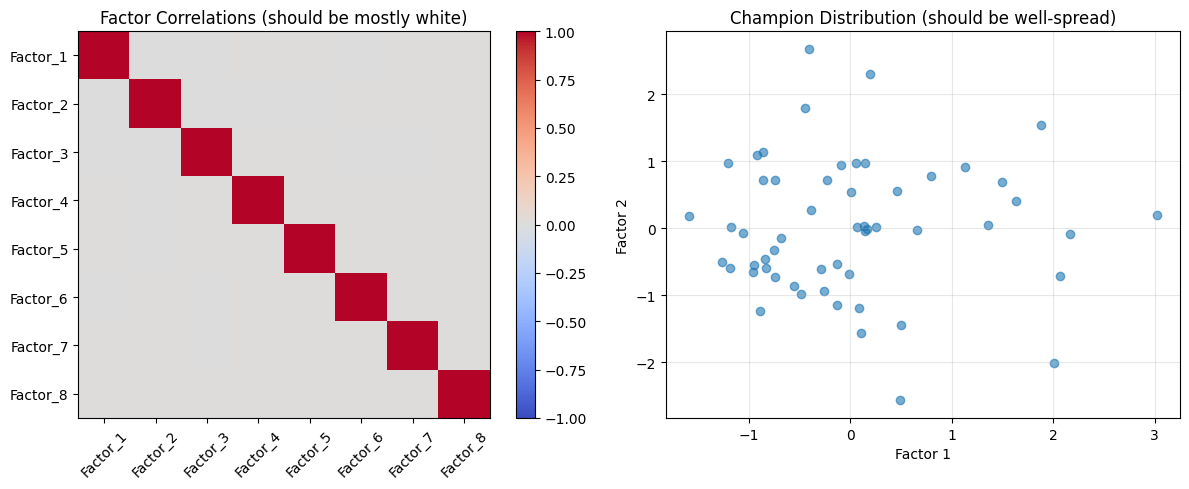


CLUSTER EXPLORATION
Testing k = 3 to 10

RESULTS:
    k  kmeans_silhouette  kmeans_ch  gmm_silhouette    gmm_ch      gmm_bic  \
0   3           0.083379   5.592068        0.154579  4.011331  1335.971562   
1   4           0.091759   5.838830        0.078803  4.880972  1327.928015   
2   5           0.068900   5.556917        0.090532  4.910344  1152.356537   
3   6           0.097828   5.363434        0.063204  4.848284  1303.189260   
4   7           0.082025   5.363897        0.098363  5.264793  1305.438750   
5   8           0.095621   5.578092        0.085743  5.028902  1244.163327   
6   9           0.090831   5.297528        0.078065  4.739206  1085.672833   
7  10           0.101280   5.345840        0.064595  4.477958  1296.382622   

   hier_silhouette   hier_ch  
0         0.146764  5.133595  
1         0.096179  5.410908  
2         0.112045  5.629479  
3         0.096020  5.781020  
4         0.091786  5.860317  
5         0.109488  6.028890  
6         0.114704  6.036869 

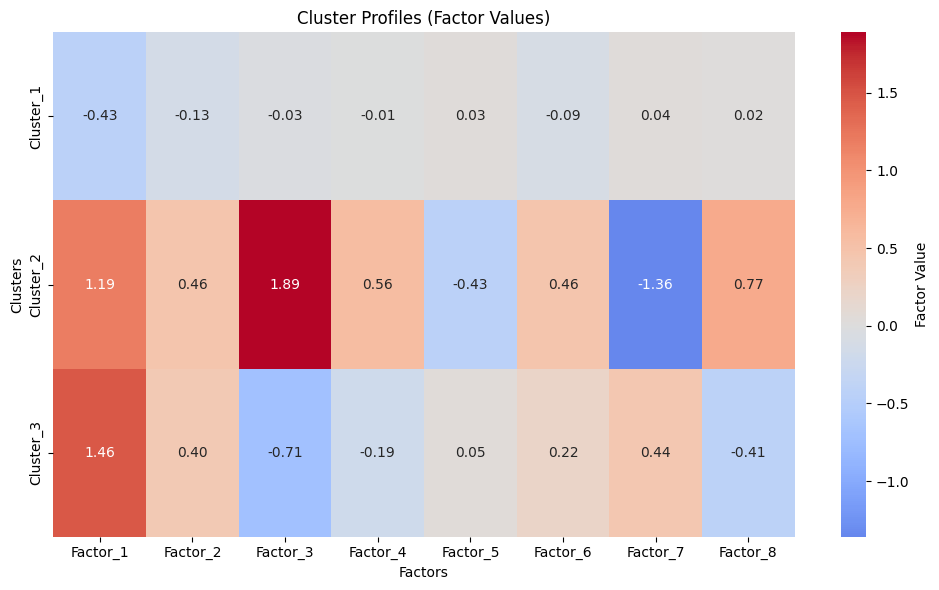

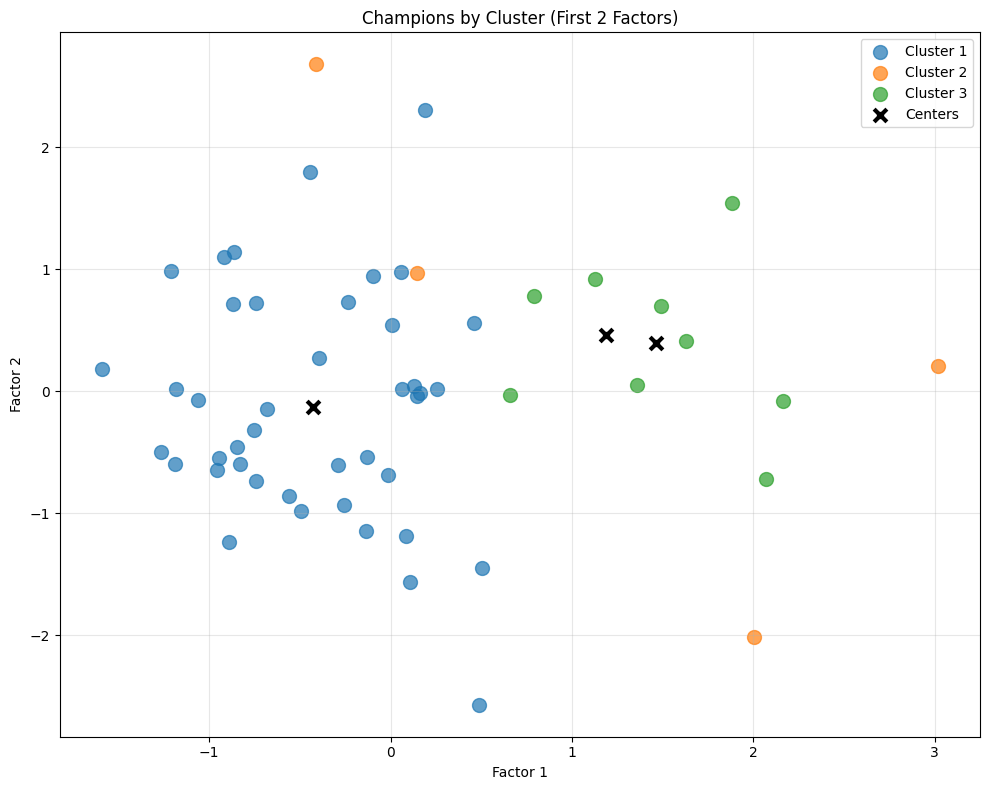


2. CLUSTER SEPARATION QUALITY
----------------------------------------
Average cluster separation: 2.95
Minimum cluster separation: 2.19
✓ Clusters are well separated

HIERARCHICAL CLUSTERING INTERPRETATION

HIERARCHICAL CLUSTER CHARACTERISTICS:
----------------------------------------

Cluster_1 (42 champions)
  Examples: Warwick, Udyr, Belveth, Kayn, MonkeyKing
  Key features:
    avg_quadrakills: +24.6%
    avg_legendary_count: +18.7%
    avg_doublekills: +15.0%
    pct_of_matches_with_health: -13.7%
    pct_of_games_with_lanephase_gold_exp_adv: +13.4%
    avg_total_physical_damage_dealt: +13.0%
    avg_solo_kills: +12.3%
    avg_kills_near_enemy_turret: +11.3%
    pct_of_games_with_early_lane_phase_gold_exp_adv: +11.0%
    avg_outnumbered_kills: +11.0%

Cluster_2 (4 champions)
  Examples: Yorick, Ivern, JarvanIV, Trundle
  Key features:
    pct_of_games_indiv_killed_1st_tower: +83.0%
    avg_indiv_turret_plates_taken: +82.8%
    pct_of_games_individual_had_1st_turret_assist: +78.8

(champion_name
 Warwick         0
 Sejuani         8
 Yorick          1
 Ivern           6
 Udyr            1
 Belveth         1
 Kayn            7
 MonkeyKing      1
 RekSai          0
 Lillia          7
 MasterYi        2
 Shaco           5
 Maokai          8
 Amumu           5
 Pantheon        0
 Olaf            1
 Zac             8
 Kindred         2
 Ekko            0
 Nidalee         2
 Shyvana         1
 Briar           0
 Taliyah         4
 Zyra            5
 DrMundo         1
 Rumble          0
 Skarner         8
 Poppy           5
 Rengar          7
 FiddleSticks    5
 Nocturne        7
 Viego           2
 Gragas          5
 Zed             7
 JarvanIV        9
 Darius          1
 Qiyana          2
 Evelynn         2
 Rammus          5
 XinZhao         0
 Karthus         4
 Khazix          2
 Graves          2
 Nunu            0
 Hecarim         7
 Elise           0
 Volibear        1
 Naafiri         0
 Gwen            1
 Trundle         3
 Vi              1
 LeeSin         

In [350]:
create_role_clusters_new(jungle_filtered_df, "jungle")